# Import Required Libraries

In [1]:
import sys
import os
sys.path.append("../../src")

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import pylab as pl

from WSMBSS import *

import warnings
warnings.filterwarnings("ignore")

notebook_name = 'Nonnegative_Antisparse_Copula'

# Source Generation and Mixing Scenario

In [2]:
np.random.seed(100)
rho = 0.5
N = 500000
NumberofSources = 5
NumberofMixtures = 10

# NoiseAmp = (10 ** (-SNR/20))# * np.sqrt(NumberofSources)

S = generate_correlated_copula_sources(rho = rho, df = 4, n_sources = NumberofSources, size_sources = N , 
                                       decreasing_correlation = True)

INPUT_STD = 0.28
A, X = WSM_Mixing_Scenario(S, NumberofMixtures, INPUT_STD)

SNR=30
X, NoisePart = addWGN(X, SNR, return_noise = True)

SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 29.99847169729263


In [3]:
if rho > 0.4:
    gamma_start = 0.05
    gamma_stop = 5*1e-4
else:
    gamma_start = 0.1
    gamma_stop = 1e-3
OUTPUT_COMP_TOL = 1e-7
MAX_OUT_ITERATIONS= 3000
LayerGains = [1,1]
LayerMinimumGains = [1e-3,1e-3]
LayerMaximumGains = [1e6,20]
WScalings = [0.0033,0.0033]
GamScalings = [2,1]
zeta = 1*1e-5
beta = 0.5
muD = [1, 1e-2]

s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = s_dim
samples = S.shape[1]
W_HX = np.eye(h_dim, x_dim)
W_YH = np.eye(s_dim, h_dim)

H = np.zeros((h_dim,samples))
Y = np.zeros((s_dim,samples))

In [8]:
debug_iteration_point = 10000
modelWSM = OnlineWSMBSS( s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
                         gamma_start = gamma_start, gamma_stop = gamma_stop, beta = beta, zeta = zeta, 
                         muD = muD,WScalings = WScalings, GamScalings = GamScalings,
                         W_HX = W_HX, W_YH = W_YH,
                         DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
                         LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
                         set_ground_truth = True, S = S, A = A)

In [9]:
neural_dynamic_iterations = 500
neural_lr_start = 0.75
neural_lr_stop = 0.05
OUTPUT_COMP_TOL = 1e-5

W_HX = modelWSM.W_HX
W_YH = modelWSM.W_YH
M_H = modelWSM.M_H
M_Y = modelWSM.M_Y
D1 = modelWSM.D1
D2 = modelWSM.D2

H = np.zeros((h_dim,samples))
Y = np.zeros((s_dim,samples))

i_sample = 0

x_current  = X[:,i_sample] # Take one input
y = Y[:,i_sample]
h = H[:,i_sample]

# modelWSM.run_neural_dynamics_nnantisparse_jit(x_current, h, y, M_H, M_Y, 
#                                             W_HX, W_YH, D1, D2, beta, zeta, neural_dynamic_iterations, 
#                                             neural_lr_start, neural_lr_stop, OUTPUT_COMP_TOL)
modelWSM.fit_batch_nnantisparse( X[:,[0]].reshape(-1,1), n_epochs = 1, 
                                 neural_dynamic_iterations = 500,
                                 neural_lr_start = 0.75,
                                 neural_lr_stop = 0.05,
                                 neural_fast_start = False,
                                 whiten = False,
                                 debug_iteration_point = debug_iteration_point,
                                 plot_in_jupyter = True,
                                )

100%|██████████| 1/1 [00:08<00:00,  8.60s/it]

shapes (5,1) and (500000,5) not aligned: 1 (dim 1) != 500000 (dim 0)


<Figure size 5600x4000 with 0 Axes>

In [13]:
modelWSM.D2

array([[0.99999991, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9999999 , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.9999999 , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.9999999 , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.9999999 ]])

# Visualize Generated Sources and Mixtures

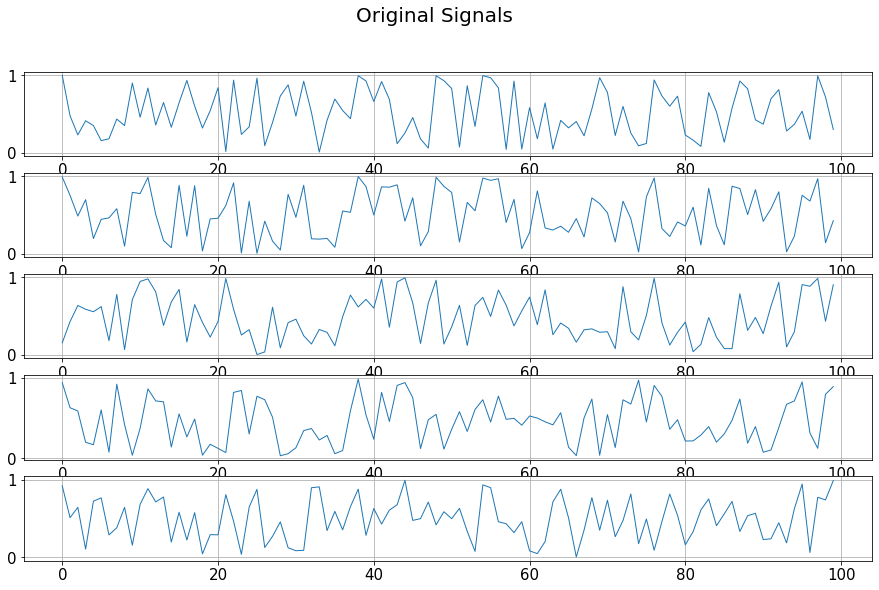

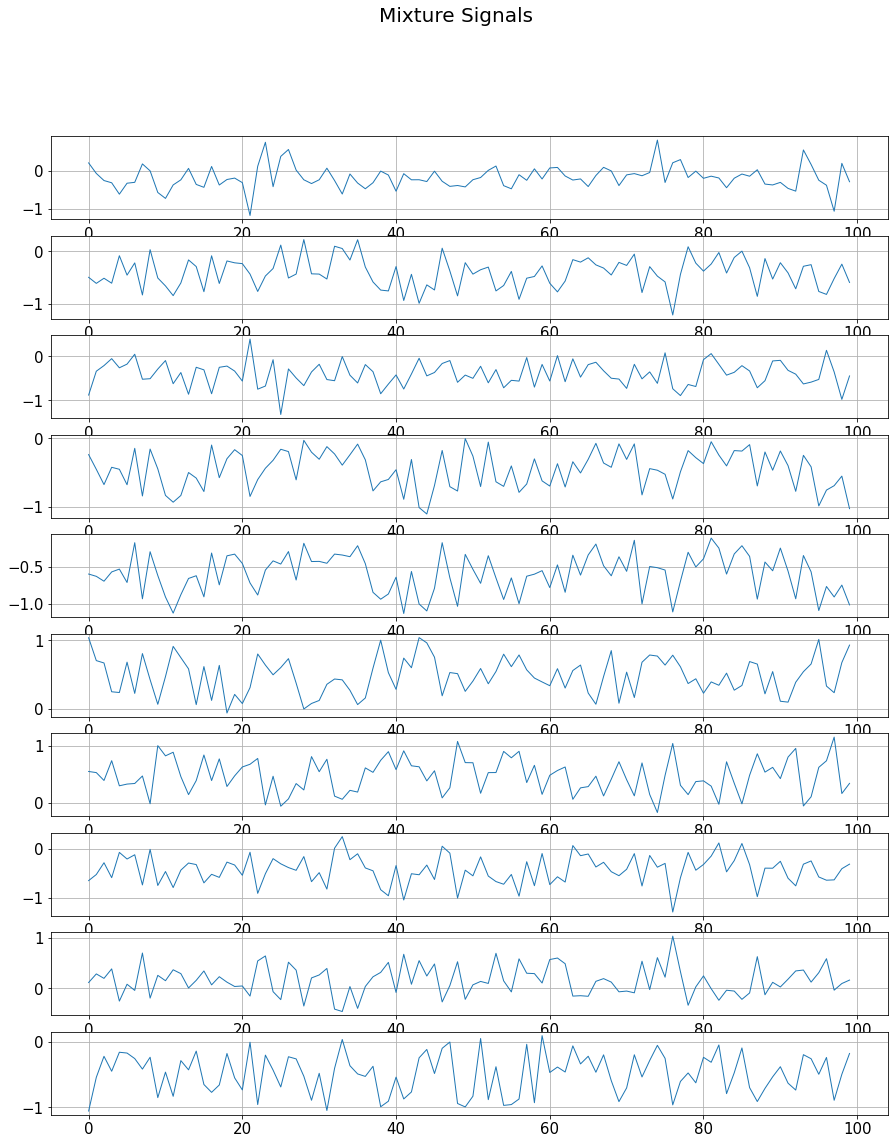

In [3]:
subplot_1D_signals(S.T[0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X.T[0:100], title = 'Mixture Signals', figsize = (15,18), colorcode = None)

# Algorithm Hyperparameter Selection and Weight Initialization

In [4]:
if rho > 0.4:
    gamma_start = 0.05
    gamma_stop = 5*1e-4
else:
    gamma_start = 0.1
    gamma_stop = 1e-3
OUTPUT_COMP_TOL = 1e-7
MAX_OUT_ITERATIONS= 3000
LayerGains = [1,1]
LayerMinimumGains = [1e-3,1e-3]
LayerMaximumGains = [1e6,20]
WScalings = [0.0033,0.0033]
GamScalings = [2,1]
zeta = 1*1e-5
beta = 0.5
muD = [1, 1e-2]

s_dim = S.shape[0]
x_dim = X.shape[0]
h_dim = s_dim
samples = S.shape[1]
W_HX = np.eye(h_dim, x_dim)
W_YH = np.eye(s_dim, h_dim)

# Run WSM Algorithm on Mixture Signals

In [5]:
# debug_iteration_point = 10000
# modelWSM = OnlineWSMBSS( s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
#                          gamma_start = gamma_start, gamma_stop = gamma_stop, beta = beta, zeta = zeta, 
#                          muD = muD,WScalings = WScalings, GamScalings = GamScalings,
#                          W_HX = W_HX, W_YH = W_YH,
#                          DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
#                          LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
#                          set_ground_truth = True, S = S, A = A)

In [6]:
# neural_dynamic_iterations = 500
# neural_lr_start = 0.75
# neural_lr_stop = 0.05
# OUTPUT_COMP_TOL = 1e-5

# W_HX = modelWSM.W_HX
# W_YH = -modelWSM.W_YH
# M_H = modelWSM.M_H
# M_Y = modelWSM.M_Y
# D1 = modelWSM.D1
# D2 = modelWSM.D2

# H = np.zeros((h_dim,samples))
# Y = np.zeros((s_dim,samples))

# i_sample = 97

# x_current  = X[:,i_sample] # Take one input
# y = Y[:,i_sample]
# h = H[:,i_sample]

# modelWSM.run_neural_dynamics_nnantisparse_jit(x_current, h, y, M_H, M_Y, 
#                                             W_HX, W_YH, D1, D2, beta, zeta, neural_dynamic_iterations, 
#                                             neural_lr_start, neural_lr_stop, OUTPUT_COMP_TOL)

In [7]:
debug_iteration_point = 10000
modelWSM = OnlineWSMBSS( s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
                         gamma_start = gamma_start, gamma_stop = gamma_stop, beta = beta, zeta = zeta, 
                         muD = muD,WScalings = WScalings, GamScalings = GamScalings,
                         W_HX = W_HX, W_YH = W_YH,
                         DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
                         LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
                         set_ground_truth = True, S = S, A = A)

In [8]:
modelWSM.compute_overall_mapping(return_mapping = True)

array([[0.33333333, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.33333333, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.33333333, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.33333333, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.33333333,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

In [9]:
modelWSM.fit_batch_nnantisparse( X[:,[0,1]].reshape(-1,2), n_epochs = 1, 
                                 neural_dynamic_iterations = 500,
                                 neural_lr_start = 0.75,
                                 neural_lr_stop = 0.05,
                                 neural_fast_start = False,
                                 whiten = False,
                                 debug_iteration_point = debug_iteration_point,
                                 plot_in_jupyter = True,
                                )

  0%|          | 0/2 [00:00<?, ?it/s]

[-0.01609739 -0.15184027 -0.08548395 -0.11261579 -0.15696692]
[0. 0. 0. 0. 0.]
15


100%|██████████| 2/2 [00:13<00:00,  6.55s/it]

[[1.90001296e+00 1.22211611e-04]
 [1.22211611e-04 1.90115277e+00]]
[[0.95 0.  ]
 [0.   0.95]]
[[9.50051825e-01 4.88844341e-04]
 [4.88844341e-04 9.54611074e-01]]
[[0.95 0.  ]
 [0.   0.95]]
operands could not be broadcast together with shapes (500000,5,1) (2,1,5) 
[ 0.0709069  -0.12876442 -0.22448123 -0.06319887 -0.1551329 ]
[0.07090691 0.         0.         0.         0.        ]
32
[[ 1.81140550e+00 -3.10425197e-04]
 [-3.10425197e-04  1.81303220e+00]]
[[0.90581412 0.        ]
 [0.         0.90557903]]
[[ 9.06341871e-01 -1.16467900e-03]
 [-8.29598118e-04  9.12935723e-01]]
[[ 9.05814121e-01 -4.26922345e-04]
 [ 0.00000000e+00  9.05579027e-01]]


<Figure size 5600x4000 with 0 Axes>

In [10]:
modelWSM.neural_OUTPUT_COMP_TOL

1e-07

In [11]:
modelWSM.compute_overall_mapping(return_mapping = True)

array([[ 3.33574792e-01, -7.23582529e-04, -1.30179404e-03,
        -3.46568601e-04, -8.77602677e-04,  1.31188853e-03,
         6.91804282e-04, -8.23879209e-04,  1.48378307e-04,
        -1.33428407e-03],
       [-4.11270318e-04,  3.34214645e-01,  1.58550298e-03,
         4.22098682e-04,  1.06886467e-03, -2.23479445e-03,
        -1.17848455e-03,  1.40347342e-03, -2.52761578e-04,
         2.27294512e-03],
       [-7.39914559e-04,  1.58550298e-03,  3.36185838e-01,
         7.59395820e-04,  1.92298957e-03, -4.02060852e-03,
        -2.12020620e-03,  2.52498265e-03, -4.54742206e-04,
         4.08924523e-03],
       [-1.96982891e-04,  4.22098682e-04,  7.59395820e-04,
         3.33535536e-01,  5.11945658e-04, -1.07038182e-03,
        -5.64449425e-04,  6.72210563e-04, -1.21063214e-04,
         1.08865454e-03],
       [-4.98812392e-04,  1.06886467e-03,  1.92298957e-03,
         5.11945658e-04,  3.34629747e-01, -2.71048776e-03,
        -1.42933412e-03,  1.70221361e-03, -3.06563839e-04,
         2.

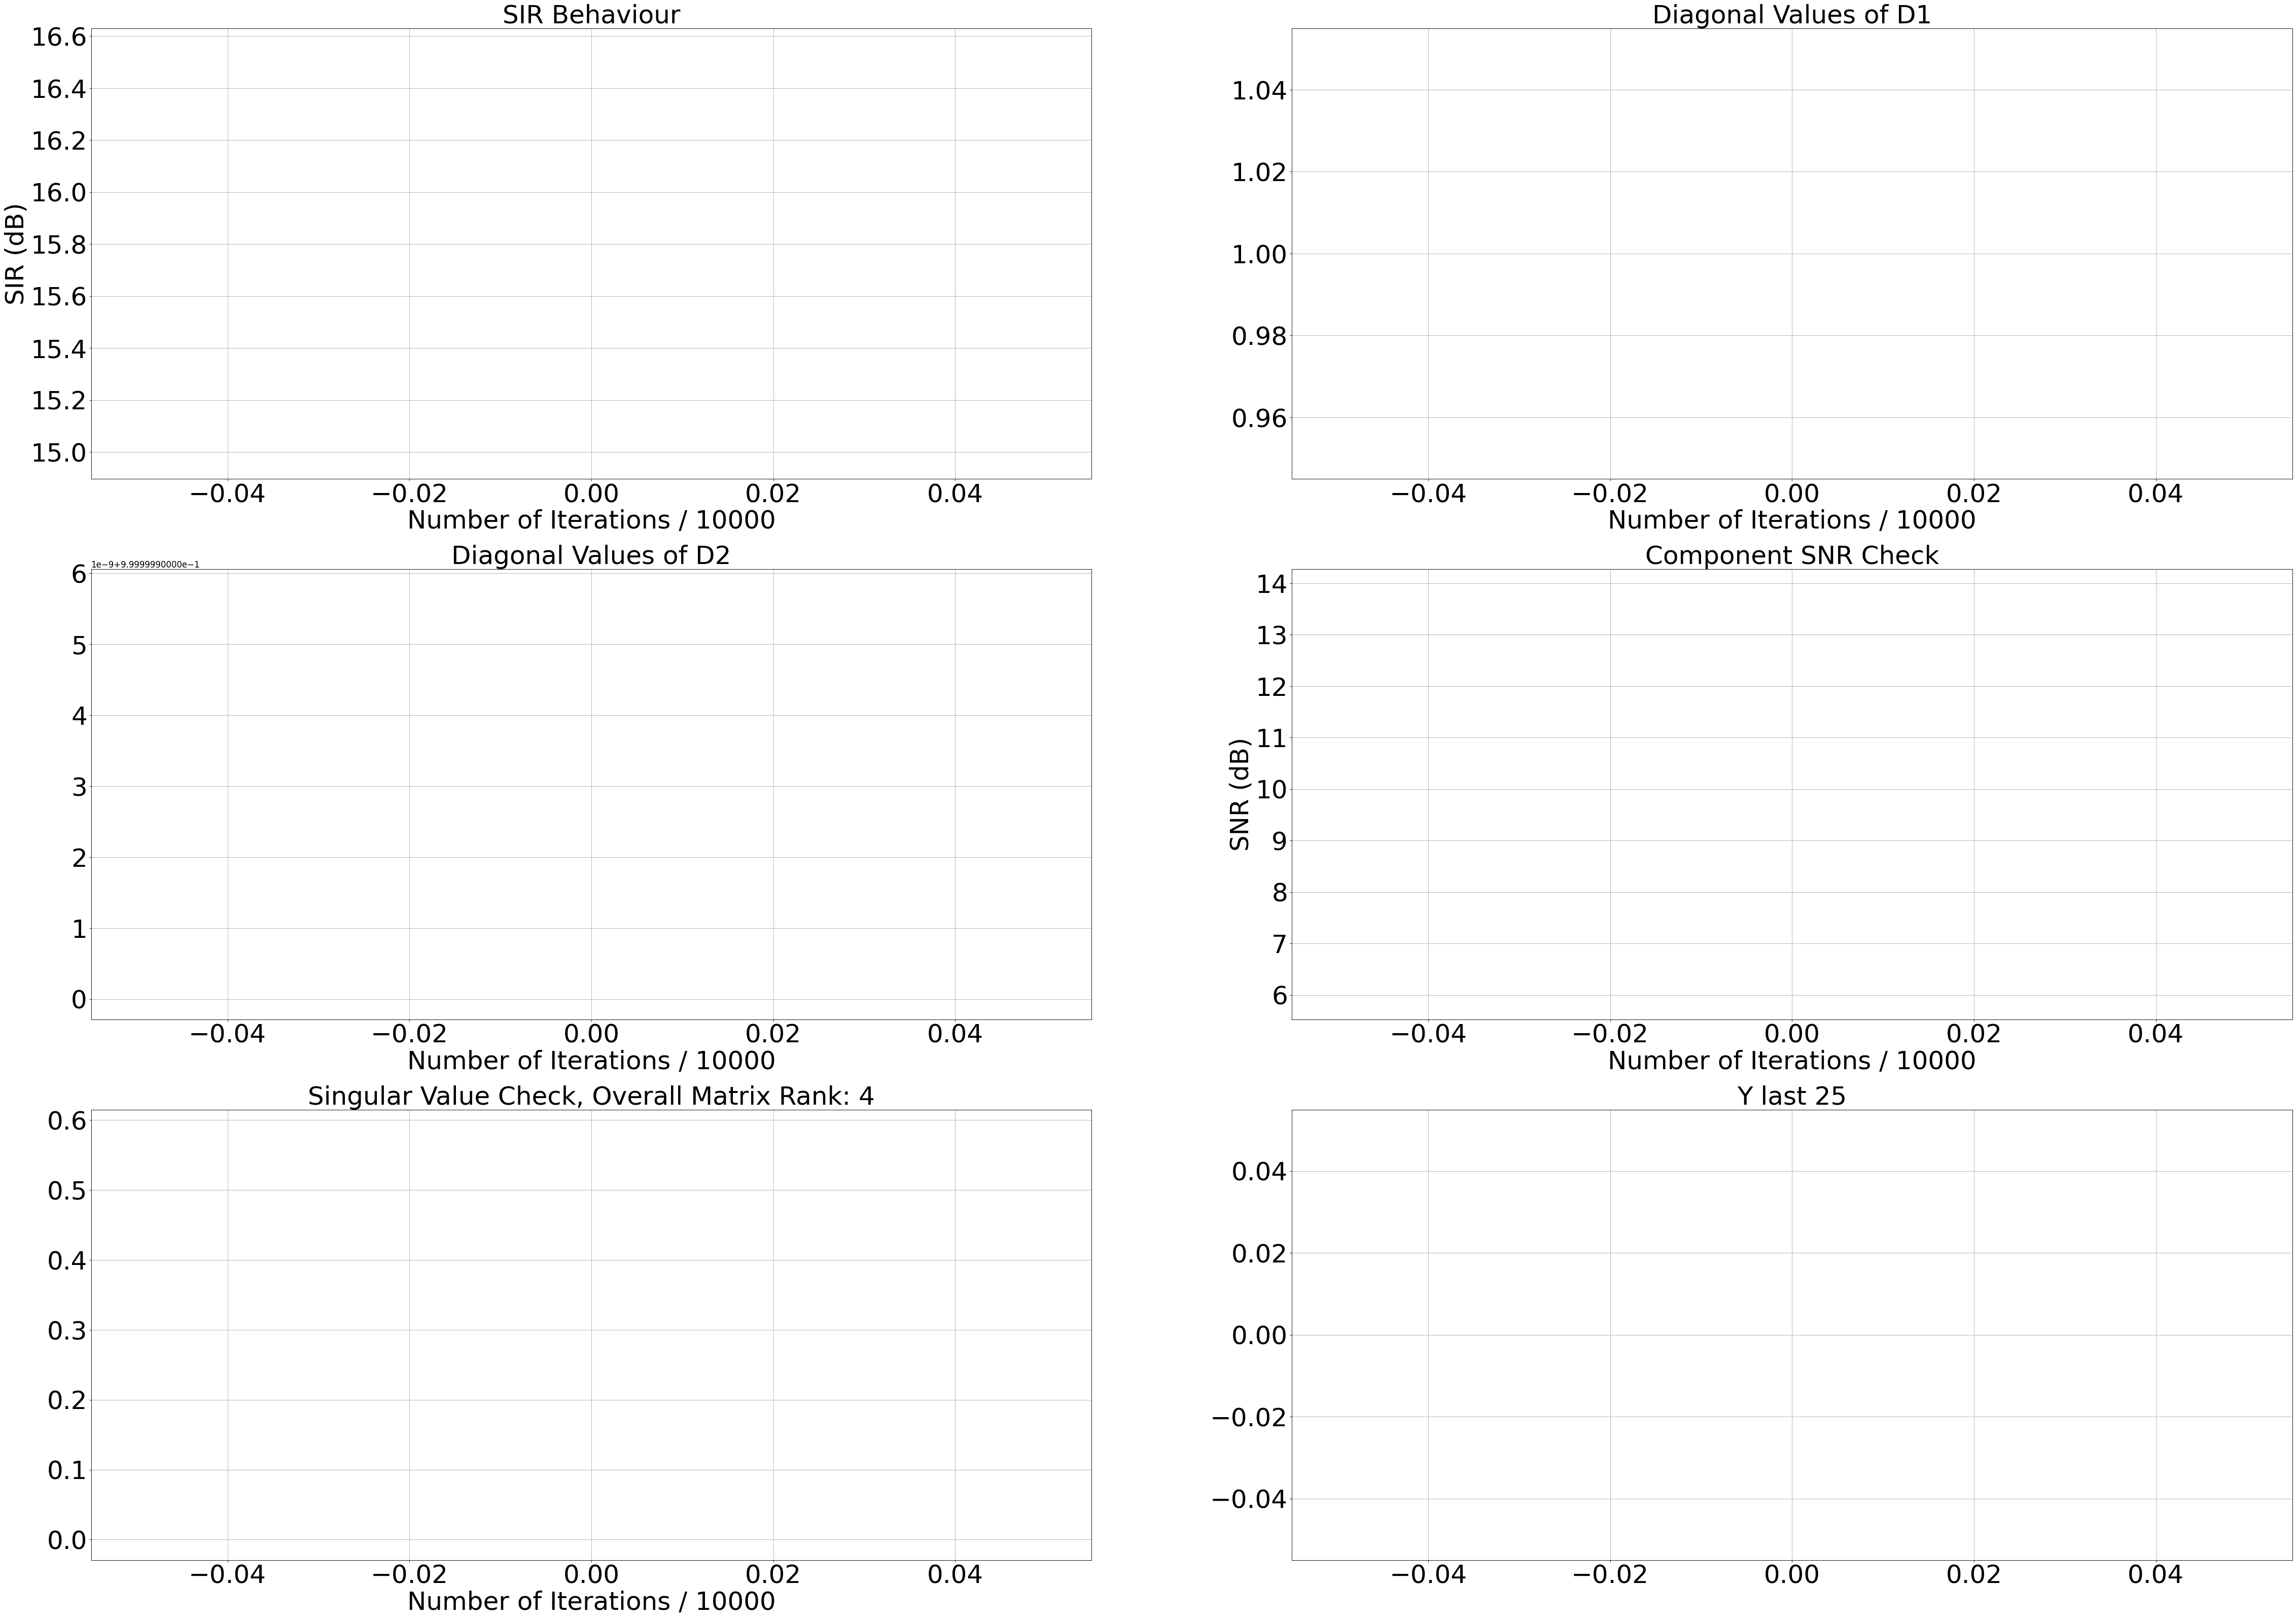

  0%|          | 88/500000 [00:04<4:49:16, 28.80it/s] 

[-0.0133561  -0.15653946 -0.09393823 -0.11486652 -0.16266636]
[0. 0. 0. 0. 0.]
15
[-0.06161888 -0.13496227 -0.06224374 -0.1730285  -0.18205683]
[0. 0. 0. 0. 0.]
14
[-0.07782769 -0.16174229 -0.02420298 -0.11388649 -0.15470964]
[0. 0. 0. 0. 0.]
14
[-0.15486899 -0.02786804 -0.07154436 -0.11868929 -0.14102074]
[0. 0. 0. 0. 0.]
14
[-0.08495725 -0.12645269 -0.05612333 -0.18146949 -0.19533674]
[0. 0. 0. 0. 0.]
14
[-0.02161138 -0.01759521  0.00313587 -0.01234843 -0.01518343]
[0.         0.         0.00313587 0.         0.        ]
500
[ 0.03667618 -0.11633626 -0.07431154 -0.1171408  -0.13573207]
[0.03689465 0.         0.         0.         0.        ]
500
[-7.65144656e-05  2.29511819e-04 -6.53790859e-02 -2.30321292e-02
 -4.21482423e-02]
[3.58666700e-05 2.29511745e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
500
[-0.07083201 -0.0752553  -0.0449805  -0.06728622 -0.09460064]
[0. 0. 0. 0. 0.]
14
[-0.09247151 -0.09729069 -0.02328659 -0.11891349 -0.13669914]
[0. 0. 0. 0. 0.]
14
[-0.05373998 -0

  0%|          | 151/500000 [00:05<2:14:28, 61.95it/s]

[ 0.53426995 -0.21849672 -0.25882539 -0.23480179 -0.41896033]
[0.78336328 0.         0.         0.         0.        ]
500
[ 0.63675289 -0.23669138 -0.30281449 -0.33825939 -0.53112244]
[0.97299932 0.         0.         0.         0.        ]
500
[ 0.0518345  -0.41012974 -0.21238785 -0.61644249 -1.14713847]
[1. 0. 0. 0. 0.]
76
[ 0.3018646  -0.45971764  0.0646397  -0.50290186 -0.83398908]
[1.         0.         0.06572757 0.         0.        ]
78
[ 0.05319073 -0.35275854 -0.17040218 -0.51433584 -1.07331878]
[1. 0. 0. 0. 0.]
83
[ 0.47698052 -0.21089378 -0.46896456 -0.39415914 -0.73836943]
[1. 0. 0. 0. 0.]
81
[ 0.23831849 -0.30315082 -0.16650701 -0.59063555 -0.90597698]
[1. 0. 0. 0. 0.]
113
[ 0.0976762  -0.23733694 -0.52836141 -0.47442719 -1.07985471]
[1. 0. 0. 0. 0.]
148
[ 0.57540319 -0.15426388 -0.50051025 -0.34845456 -0.60513128]
[1. 0. 0. 0. 0.]
107
[ 0.24629032 -0.34701169 -0.14739506 -0.4988824  -0.91162665]
[1. 0. 0. 0. 0.]
174
[ 0.26240472 -0.35813464 -0.02832065 -0.49028555 -0.85

  0%|          | 206/500000 [00:05<1:26:31, 96.27it/s]

500
[ 0.47337509  0.13533432  0.20808656 -0.61831693 -0.89017042]
[1.         0.24223765 0.45453018 0.         0.        ]
500
[ 0.50609722 -0.02873361 -0.00402661 -0.2800052  -0.92323342]
[1.         0.07823602 0.33271007 0.         0.        ]
500
[ 0.56159328 -0.2919279  -0.04381674 -0.41439968 -0.61918003]
[0.9558372  0.         0.07269997 0.         0.        ]
500
[ 0.41010512 -0.37866109 -0.12399297 -0.31282159 -0.39115358]
[0.70669218 0.         0.         0.         0.        ]
500
[ 0.32062494 -0.17808733  0.0744714  -0.41290687 -1.01969973]
[1.         0.         0.55984774 0.         0.        ]
500
[ 0.46098182  0.02276815 -0.25361713 -0.42275997 -0.86453864]
[1.         0.12094786 0.32450585 0.         0.        ]
500
[ 0.44254331  0.30298242 -0.00864361 -0.9343114  -0.77508578]
[1.         0.69430328 0.4621093  0.         0.        ]
500
[ 0.43906808 -0.28341457 -0.08343875 -0.36672353 -0.85116824]
[1.         0.         0.30663056 0.         0.        ]
500
[-0.06429924

  0%|          | 254/500000 [00:05<1:04:16, 129.58it/s]

[1.         0.34698521 0.36780557 0.         0.        ]
500
[ 0.45093641 -0.44982222  0.21406008 -0.3338576  -0.87781462]
[1.         0.         0.44300207 0.0656822  0.        ]
500
[ 0.40766826  0.12237273 -0.01494088 -0.35082298 -0.56396397]
[0.66364366 0.36978992 0.18196705 0.00169639 0.        ]
500
[ 0.38009208 -0.44739434 -0.14858773 -0.35570674 -0.25723074]
[0.62704928 0.         0.         0.00117987 0.        ]
217
[ 0.35492735 -0.90066607  0.03502855 -0.30442829 -0.95359812]
[1.         0.         0.57930565 0.34420768 0.        ]
500
[ 0.29137666  0.0537531   0.54876921 -0.58982939 -1.29571265]
[1.         0.46884389 1.         0.         0.        ]
500
[ 0.70675279  0.10027671 -0.212141   -0.28564971 -0.84500404]
[1.         0.42169349 0.12059855 0.2710864  0.        ]
500
[ 0.43235336  0.13060565 -0.27290685 -0.67662659 -0.24688649]
[0.57775851 0.49955822 0.         0.         0.        ]
226
[ 0.28682577 -0.09441487 -0.16285997  0.08622637 -0.31133233]
[0.34848772 0.  

  0%|          | 299/500000 [00:05<53:33, 155.50it/s]  

[0.63591374 0.55477435 0.         0.49294737 0.        ]
500
[ 0.11000404 -0.06123433  0.16852798 -0.25258785 -0.6910345 ]
[0.53634164 0.14300271 0.51699911 0.03053032 0.        ]
500
[ 0.52859658  0.13699195  0.01229189 -0.50650076 -0.88973308]
[0.94212307 0.54724778 0.38021194 0.0449956  0.        ]
500
[ 0.58496029 -0.2211944  -0.33501224  0.29337348 -0.79561864]
[0.77228686 0.02586339 0.03332346 0.78221809 0.        ]
500
[ 0.17536627 -0.02678509  0.04210292 -0.23349958 -0.33639461]
[0.36990828 0.13498139 0.19577093 0.         0.        ]
500
[-0.11845998 -0.4176624   0.67450254 -0.22525406 -0.5673457 ]
[0.16764362 0.         0.95774793 0.         0.        ]
500
[ 0.28480716 -0.4551233   0.1595267  -0.05579018 -0.73303945]
[0.6006423  0.         0.53306271 0.31991617 0.        ]
500
[ 0.56851037  0.18725176 -0.182699   -0.52922849 -0.42267908]
[0.69402408 0.55164613 0.         0.         0.12129256]
500
[ 0.06768843 -0.09860143  0.10097485 -0.1961863  -0.41333947]
[0.35939892 0.03

  0%|          | 341/500000 [00:06<48:29, 171.75it/s]

500
[ 0.3413361  -0.37627522  0.00715161 -0.16495284 -0.81800361]
[0.78058239 0.         0.46510618 0.31515135 0.        ]
500
[ 0.04550608 -0.18047132 -0.35870783 -0.25708986 -0.0295328 ]
[0.17157059 0.         0.         0.         0.45425893]
500
[ 0.37310772  0.62151432  0.28778563 -0.55706071 -0.79506558]
[0.48827549 1.         0.54882132 0.         0.        ]
500
[ 0.36657977 -0.40041592  0.02939667 -0.18411403 -0.68330625]
[0.72488059 0.         0.38975441 0.23012883 0.        ]
500
[ 0.36867789 -0.34593411 -0.21244447 -0.54277404 -0.46334692]
[0.82427116 0.00243258 0.15691506 0.         0.31648214]
500
[ 0.39529897  0.26155821  0.23281886 -0.40907608 -1.12323678]
[0.75943484 0.72219448 0.73382379 0.2196568  0.        ]
500
[ 0.19345319  0.18308113 -0.39531443 -0.49004706 -0.20087961]
[0.33411195 0.37518892 0.         0.         0.47131476]
252
[ 0.35858383 -0.24582777  0.04683589 -0.48114011 -0.93349268]
[0.95353665 0.19609179 0.57059435 0.10104554 0.04165671]
500
[ 0.415122  

  0%|          | 357/500000 [00:06<2:25:02, 57.42it/s]


[ 0.463215   -0.21231938 -0.20735003 -0.31320174 -0.91812003]
[0.93342262 0.21603432 0.38245774 0.37906848 0.14953345]
500



KeyboardInterrupt



Error in callback <function flush_figures at 0x2b99b819a5e0> (for post_execute):



KeyboardInterrupt



In [12]:
debug_iteration_point = 10000
modelWSM = OnlineWSMBSS( s_dim = s_dim, x_dim = x_dim, h_dim = h_dim, 
                         gamma_start = gamma_start, gamma_stop = gamma_stop, beta = beta, zeta = zeta, 
                         muD = muD,WScalings = WScalings, GamScalings = GamScalings,
                         W_HX = W_HX, W_YH = W_YH,
                         DScalings = LayerGains, LayerMinimumGains = LayerMinimumGains,
                         LayerMaximumGains = LayerMaximumGains,neural_OUTPUT_COMP_TOL = OUTPUT_COMP_TOL,
                         set_ground_truth = True, S = S, A = A)

modelWSM.fit_batch_nnantisparse( X, n_epochs = 1, 
                                 neural_dynamic_iterations = 500,
                                 neural_lr_start = 0.75,
                                 neural_lr_stop = 0.05,
                                 neural_fast_start = False,
                                 whiten = False,
                                shuffle = False,
                                 debug_iteration_point = debug_iteration_point,
                                 plot_in_jupyter = True,
                                )

# Visualize SNR Convergence of Each Source Component

In [ ]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
plot_convergence_plot(modelWSM.SNR_list, xlabel = 'Number of Iterations / {}'.format(debug_iteration_point),
                     ylabel = 'SINR (dB)', title = 'SINR Convergence Plot', colorcode = None, linewidth = 1.8)

# Calculate Resulting Component SNRs and Overall SINR

In [ ]:
Wf = modelWSM.compute_overall_mapping(return_mapping = True)
Y = Wf @ X
Y_ = signed_and_permutation_corrected_sources(S,Y)
coef_ = ((Y_ * S).sum(axis = 1) / (Y_ * Y_).sum(axis = 1)).reshape(-1,1)
Y_ = coef_ * Y_

print("Component SNR Values : {}\n".format(snr_jit(S, Y_)))

SINRwsm = 10*np.log10(CalculateSINRjit(Y_, S)[0])

print("Overall SINR : {}".format(SINRwsm))

# Vizualize Extracted Signals Compared to Original Sources

In [ ]:
subplot_1D_signals(Y_[:,0:100], title = 'Extracted Signals (Sign and Permutation Corrected)', figsize = (15.2,9), colorcode = None)
subplot_1D_signals(S[:,0:100], title = 'Original Signals', figsize = (15.2,9), colorcode = None)